In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import pandas as pd
import torch
from torch.nn.functional import cross_entropy
from tqdm import tqdm
from google.colab import files ,drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Configuration
MODEL_NAME = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
LEARNING_RATE = 5e-5
EPOCHS = 1
BATCH_SIZE = 64
SAVE_DIR = "saved_models"

# Load dataset
df = pd.read_parquet("hf://datasets/TimKoornstra/synthetic-financial-tweets-sentiment/data/train-00000-of-00001.parquet")

# Encode labels
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

# Split the dataset into 4 non-overlapping balanced datasets
split_size = len(df) // 4
balanced_datasets = []
for i in range(4):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size if i < 3 else len(df)
    split_df = df.iloc[start_idx:end_idx].copy()
    balanced_datasets.append(split_df)
    print(f"Dataset {i+1} label distribution:")
    print(split_df['sentiment'].value_counts())

# Save datasets to objects
dataset_objects = {}
for i, split_df in enumerate(balanced_datasets):
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        split_df['tweet'].tolist(),
        split_df['sentiment'].tolist(),
        test_size=0.2,
        stratify=split_df['sentiment']
    )

    # Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    # Dataset Class
    class TweetDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length=128):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]
            inputs = self.tokenizer(
                text,
                max_length=self.max_length,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
            return {
                "input_ids": inputs["input_ids"].squeeze(),
                "attention_mask": inputs["attention_mask"].squeeze(),
                "labels": torch.tensor(label, dtype=torch.long)
            }

    # Prepare datasets and dataloaders
    train_dataset = TweetDataset(train_texts, train_labels, tokenizer)
    val_dataset = TweetDataset(val_texts, val_labels, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    dataset_objects[f"dataset_{i+1}"] = {
        "train_loader": train_loader,
        "val_loader": val_loader,
        "train_texts": train_texts,
        "val_texts": val_texts,
        "train_labels": train_labels,
        "val_labels": val_labels
    }

# Load model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(label_encoder.classes_))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Datasets and loaders created.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset 1 label distribution:
sentiment
2    122019
1    121535
0    113638
Name: count, dtype: int64
Dataset 2 label distribution:
sentiment
2    121598
1    121410
0    114184
Name: count, dtype: int64
Dataset 3 label distribution:
sentiment
2    121536
1    121431
0    114225
Name: count, dtype: int64
Dataset 4 label distribution:
sentiment
1    121990
2    120980
0    114225
Name: count, dtype: int64


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Datasets and loaders created.


In [ ]:
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

dataset_key = "dataset_1"
train_loader = dataset_objects[dataset_key]["train_loader"]
val_loader = dataset_objects[dataset_key]["val_loader"]

model.train()
train_progress = tqdm(train_loader, desc="Training Epoch 1")
for batch in train_progress:
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

    train_progress.set_postfix(loss=loss.item())

# Validation phase
model.eval()
val_loss = 0
correct = 0
total = 0
val_progress = tqdm(val_loader, desc="Validation Epoch 1")
with torch.no_grad():
    for batch in val_progress:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += outputs.loss.item()
        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

val_loss /= len(val_loader)
accuracy = correct / total
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")



/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1: 100%|██████████| 1117/1117 [02:01<00:00,  9.20it/s]


Validation Loss: 0.1700, Accuracy: 0.9354


RuntimeError: Parent directory saved_models does not exist.

In [ ]:
# Save the model and tokenizer
model_save_path = f"{SAVE_DIR}/model_epoch_1.pt"
tokenizer_save_path = f"{SAVE_DIR}/tokenizer_epoch_1"
torch.save(model.state_dict(), model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

print(f"Epoch 1 completed and saved: {model_save_path}")
print("Training on first dataset completed.")

Epoch 1 completed and saved: saved_models/model_epoch_1.pt
Training on first dataset completed.


In [ ]:

# Load tokenizer and model from epoch 1
tokenizer = AutoTokenizer.from_pretrained(f"{SAVE_DIR}/tokenizer_epoch_1")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(label_encoder.classes_))
model.load_state_dict(torch.load(f"{SAVE_DIR}/model_epoch_1.pt"))
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-7-e6232056be20>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (Se

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
# Training loop for one epoch on the second dataset
optimizer = AdamW(model.parameters(), lr=4e-5)

dataset_key = "dataset_2"
train_loader = dataset_objects[dataset_key]["train_loader"]
val_loader = dataset_objects[dataset_key]["val_loader"]

model.train()
train_progress = tqdm(train_loader, desc="Training on Dataset 2")
for batch in train_progress:
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(model.device)
    attention_mask = batch["attention_mask"].to(model.device)
    labels = batch["labels"].to(model.device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

    train_progress.set_postfix(loss=loss.item())

# Validation phase
model.eval()
val_loss = 0
correct = 0
total = 0
val_progress = tqdm(val_loader, desc="Validation on Dataset 2")
with torch.no_grad():
    for batch in val_progress:
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        labels = batch["labels"].to(model.device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += outputs.loss.item()
        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

val_loss /= len(val_loader)
accuracy = correct / total
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

# Save the model and tokenizer
model_save_path = f"{SAVE_DIR}/model_epoch_2.pt"
tokenizer_save_path = f"{SAVE_DIR}/tokenizer_epoch_2"
torch.save(model.state_dict(), model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

print(f"Training on Dataset 2 completed and saved: {model_save_path}")

Validation on Dataset 2: 100%|██████████| 1117/1117 [02:02<00:00,  9.15it/s]


Validation Loss: 0.1594, Accuracy: 0.9399
Training on Dataset 2 completed and saved: saved_models/model_epoch_2.pt


In [ ]:

# Load tokenizer and model from epoch 1
tokenizer = AutoTokenizer.from_pretrained(f"{SAVE_DIR}/tokenizer_epoch_2")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(label_encoder.classes_))
model.load_state_dict(torch.load(f"{SAVE_DIR}/model_epoch_2.pt"))
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-9-13fbbfa1b901>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (Se

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
# Training loop for one epoch on the second dataset
optimizer = AdamW(model.parameters(), lr=4e-5)

dataset_key = "dataset_3"
train_loader = dataset_objects[dataset_key]["train_loader"]
val_loader = dataset_objects[dataset_key]["val_loader"]

model.train()
train_progress = tqdm(train_loader, desc="Training on Dataset 3")
for batch in train_progress:
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(model.device)
    attention_mask = batch["attention_mask"].to(model.device)
    labels = batch["labels"].to(model.device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

    train_progress.set_postfix(loss=loss.item())

# Validation phase
model.eval()
val_loss = 0
correct = 0
total = 0
val_progress = tqdm(val_loader, desc="Validation on Dataset 3")
with torch.no_grad():
    for batch in val_progress:
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        labels = batch["labels"].to(model.device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += outputs.loss.item()
        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

val_loss /= len(val_loader)
accuracy = correct / total
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

# Save the model and tokenizer
model_save_path = f"{SAVE_DIR}/model_epoch_3.pt"
tokenizer_save_path = f"{SAVE_DIR}/tokenizer_epoch_3"
torch.save(model.state_dict(), model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

print(f"Training on Dataset 3 completed and saved: {model_save_path}")

Validation on Dataset 3: 100%|██████████| 1117/1117 [02:02<00:00,  9.15it/s]


Validation Loss: 0.1552, Accuracy: 0.9429
Training on Dataset 3 completed and saved: saved_models/model_epoch_3.pt


In [ ]:

# Load tokenizer and model from epoch 1
tokenizer = AutoTokenizer.from_pretrained(f"{SAVE_DIR}/tokenizer_epoch_3")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(label_encoder.classes_))
model.load_state_dict(torch.load(f"{SAVE_DIR}/model_epoch_3.pt"))
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-11-dd513ec3e4ef>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (S

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
# Training loop for one epoch on the second dataset
optimizer = AdamW(model.parameters(), lr=3e-5)

dataset_key = "dataset_4"
train_loader = dataset_objects[dataset_key]["train_loader"]
val_loader = dataset_objects[dataset_key]["val_loader"]

model.train()
train_progress = tqdm(train_loader, desc="Training on Dataset 4")
for batch in train_progress:
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(model.device)
    attention_mask = batch["attention_mask"].to(model.device)
    labels = batch["labels"].to(model.device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

    train_progress.set_postfix(loss=loss.item())

# Validation phase
model.eval()
val_loss = 0
correct = 0
total = 0
val_progress = tqdm(val_loader, desc="Validation on Dataset 4")
with torch.no_grad():
    for batch in val_progress:
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        labels = batch["labels"].to(model.device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += outputs.loss.item()
        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

val_loss /= len(val_loader)
accuracy = correct / total
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

# Save the model and tokenizer
model_save_path = f"{SAVE_DIR}/model_epoch_4.pt"
tokenizer_save_path = f"{SAVE_DIR}/tokenizer_epoch_4"
torch.save(model.state_dict(), model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

print(f"Training on Dataset 4 completed and saved: {model_save_path}")

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation on Dataset 4: 100%|██████████| 1117/1117 [02:02<00:00,  9.10it/s]


Validation Loss: 0.1400, Accuracy: 0.9467
Training on Dataset 4 completed and saved: saved_models/model_epoch_4.pt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(label_encoder.classes_))
model.load_state_dict(torch.load(f"/content/drive/MyDrive/Roberta Weights /model_epoch_4.pt"))
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-26-1d2ec53bb0ce>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (S

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
# Training loop for one epoch on the second dataset
optimizer = AdamW(model.parameters(), lr=2e-5)

dataset_key = "dataset_4"
train_loader = dataset_objects[dataset_key]["train_loader"]
val_loader = dataset_objects[dataset_key]["val_loader"]

model.train()
train_progress = tqdm(train_loader, desc="Training on Dataset 4")
for batch in train_progress:
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(model.device)
    attention_mask = batch["attention_mask"].to(model.device)
    labels = batch["labels"].to(model.device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

    train_progress.set_postfix(loss=loss.item())

# Validation phase
model.eval()
val_loss = 0
correct = 0
total = 0
val_progress = tqdm(val_loader, desc="Validation on Dataset 4")
with torch.no_grad():
    for batch in val_progress:
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        labels = batch["labels"].to(model.device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += outputs.loss.item()
        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

val_loss /= len(val_loader)
accuracy = correct / total
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")



/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation on Dataset 4: 100%|██████████| 1117/1117 [02:01<00:00,  9.21it/s]

Validation Loss: 0.1163, Accuracy: 0.9560


In [ ]:
model_save_path = f"/content/drive/MyDrive/Roberta Weights /model_epoch_5.pt"
tokenizer_save_path = f"/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_5"
torch.save(model.state_dict(), model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

('/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_5/tokenizer_config.json',
 '/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_5/special_tokens_map.json',
 '/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_5/vocab.json',
 '/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_5/merges.txt',
 '/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_5/added_tokens.json',
 '/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_5/tokenizer.json')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(label_encoder.classes_))
model.load_state_dict(torch.load(f"/content/drive/MyDrive/Roberta Weights /model_epoch_5.pt"))
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-29-8bdf6c2fd80e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (S

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:

optimizer = AdamW(model.parameters(), lr=1e-5)

dataset_key = "dataset_4"
train_loader = dataset_objects[dataset_key]["train_loader"]
val_loader = dataset_objects[dataset_key]["val_loader"]

model.train()
train_progress = tqdm(train_loader, desc="Training on Dataset 4")
for batch in train_progress:
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(model.device)
    attention_mask = batch["attention_mask"].to(model.device)
    labels = batch["labels"].to(model.device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

    train_progress.set_postfix(loss=loss.item())

# Validation phase
model.eval()
val_loss = 0
correct = 0
total = 0
val_progress = tqdm(val_loader, desc="Validation on Dataset 4")
with torch.no_grad():
    for batch in val_progress:
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        labels = batch["labels"].to(model.device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += outputs.loss.item()
        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

val_loss /= len(val_loader)
accuracy = correct / total
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")



/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation on Dataset 4: 100%|██████████| 1117/1117 [02:01<00:00,  9.17it/s]

Validation Loss: 0.1179, Accuracy: 0.9571


In [ ]:
model_save_path = f"/content/drive/MyDrive/Roberta Weights /model_epoch_6.pt"
tokenizer_save_path = f"/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_6"
torch.save(model.state_dict(), model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

('/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_6/tokenizer_config.json',
 '/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_6/special_tokens_map.json',
 '/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_6/vocab.json',
 '/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_6/merges.txt',
 '/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_6/added_tokens.json',
 '/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_6/tokenizer.json')

In [ ]:
# Training loop for one epoch on the second dataset
optimizer = AdamW(model.parameters(), lr=1e-5)

dataset_key = "dataset_3"
train_loader = dataset_objects[dataset_key]["train_loader"]
val_loader = dataset_objects[dataset_key]["val_loader"]

model.train()
train_progress = tqdm(train_loader, desc="Training on Dataset 3")
for batch in train_progress:
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(model.device)
    attention_mask = batch["attention_mask"].to(model.device)
    labels = batch["labels"].to(model.device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

    train_progress.set_postfix(loss=loss.item())

# Validation phase
model.eval()
val_loss = 0
correct = 0
total = 0
val_progress = tqdm(val_loader, desc="Validation on Dataset 3")
with torch.no_grad():
    for batch in val_progress:
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        labels = batch["labels"].to(model.device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += outputs.loss.item()
        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

val_loss /= len(val_loader)
accuracy = correct / total
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")



/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation on Dataset 3: 100%|██████████| 1117/1117 [02:00<00:00,  9.26it/s]

Validation Loss: 0.1089, Accuracy: 0.9584


In [ ]:
model_save_path = f"/content/drive/MyDrive/Roberta Weights /model_epoch_7.pt"
tokenizer_save_path = f"/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_7"
torch.save(model.state_dict(), model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

('/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_7/tokenizer_config.json',
 '/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_7/special_tokens_map.json',
 '/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_7/vocab.json',
 '/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_7/merges.txt',
 '/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_7/added_tokens.json',
 '/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_7/tokenizer.json')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(label_encoder.classes_))
model.load_state_dict(torch.load(f"/content/drive/MyDrive/Roberta Weights /model_epoch_7.pt"))
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-47-bfb8eb29f09b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (S

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
# Training loop for one epoch on the second dataset
optimizer = AdamW(model.parameters(), lr=1e-5)

dataset_key = "dataset_2"
train_loader = dataset_objects[dataset_key]["train_loader"]
val_loader = dataset_objects[dataset_key]["val_loader"]

model.train()
train_progress = tqdm(train_loader, desc="Training on Dataset 2")
for batch in train_progress:
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(model.device)
    attention_mask = batch["attention_mask"].to(model.device)
    labels = batch["labels"].to(model.device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

    train_progress.set_postfix(loss=loss.item())

# Validation phase
model.eval()
val_loss = 0
correct = 0
total = 0
val_progress = tqdm(val_loader, desc="Validation on Dataset 2")
with torch.no_grad():
    for batch in val_progress:
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        labels = batch["labels"].to(model.device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += outputs.loss.item()
        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

val_loss /= len(val_loader)
accuracy = correct / total
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")



Validation on Dataset 2: 100%|██████████| 1117/1117 [02:00<00:00,  9.27it/s]

Validation Loss: 0.1071, Accuracy: 0.9591


In [ ]:
model_save_path = f"/content/drive/MyDrive/Roberta Weights /model_epoch_8.pt"
tokenizer_save_path = f"/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_8"
torch.save(model.state_dict(), model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

('/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_8/tokenizer_config.json',
 '/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_8/special_tokens_map.json',
 '/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_8/vocab.json',
 '/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_8/merges.txt',
 '/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_8/added_tokens.json',
 '/content/drive/MyDrive/Roberta Weights /tokenizer_epoch_8/tokenizer.json')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(label_encoder.classes_))
model.load_state_dict(torch.load(f"/content/drive/MyDrive/Roberta Weights /model_epoch_8.pt"))
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-58-732eab022552>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (S

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:

optimizer = AdamW(model.parameters(), lr=1e-5)

dataset_key = "dataset_1"
train_loader = dataset_objects[dataset_key]["train_loader"]
val_loader = dataset_objects[dataset_key]["val_loader"]

model.train()
train_progress = tqdm(train_loader, desc="Training on Dataset 1")
for batch in train_progress:
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(model.device)
    attention_mask = batch["attention_mask"].to(model.device)
    labels = batch["labels"].to(model.device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

    train_progress.set_postfix(loss=loss.item())

# Validation phase
model.eval()
val_loss = 0
correct = 0
total = 0
val_progress = tqdm(val_loader, desc="Validation on Dataset 1")
with torch.no_grad():
    for batch in val_progress:
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        labels = batch["labels"].to(model.device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += outputs.loss.item()
        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

val_loss /= len(val_loader)
accuracy = correct / total
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")



Validation on Dataset 1: 100%|██████████| 1117/1117 [02:00<00:00,  9.30it/s]

Validation Loss: 0.1086, Accuracy: 0.9591


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(label_encoder.classes_))
model.load_state_dict(torch.load(f"/content/drive/MyDrive/Roberta Weights /model_epoch_8.pt"))
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-28-732eab022552>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (S

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
###VALIDATION ON A SAMLLER NEW DATASET###
df = pd.read_parquet("hf://datasets/TimKoornstra/financial-tweets-sentiment/data/train-00000-of-00001.parquet")
print("Class distribution in full dataset:")
print(df['sentiment'].value_counts())

# Balance the dataset by taking an equal number of samples from each label
min_class_count = df['sentiment'].value_counts().min()
balanced_df = df.groupby('sentiment').apply(lambda x: x.sample(n=min_class_count, random_state=42)).reset_index(drop=True)

# Check class distribution after balancing
print("\nClass distribution after balancing:")
print(balanced_df['sentiment'].value_counts())

Class distribution in full dataset:
sentiment
1    17368
0    12181
2     8542
Name: count, dtype: int64

Class distribution after balancing:
sentiment
0    8542
1    8542
2    8542
Name: count, dtype: int64


<ipython-input-6-e263c483aaa6>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('sentiment').apply(lambda x: x.sample(n=min_class_count, random_state=42)).reset_index(drop=True)


In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, data, tokenizer, text_column, label_column, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.text_column = text_column
        self.label_column = label_column
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx][self.text_column]
        label = self.data.iloc[idx][self.label_column]

        # Tokenize with padding and truncation
        tokens = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": tokens["input_ids"].squeeze(0),
            "attention_mask": tokens["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

In [ ]:
import numpy as np
def validate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()

            # Calculate accuracy
            predictions = outputs.logits.argmax(dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy, np.array(all_predictions), np.array(all_labels)

In [ ]:
text_column = "tweet"
label_column = "sentiment"
# Define the dataset
validation_dataset1 = SentimentDataset(balanced_df, tokenizer, text_column, label_column)

# Create the DataLoader
validation_loader1 = DataLoader(validation_dataset1, batch_size=128, shuffle=False)

Validation Loss: 0.3292
Validation Accuracy: 0.8846


<Figure size 1000x800 with 0 Axes>

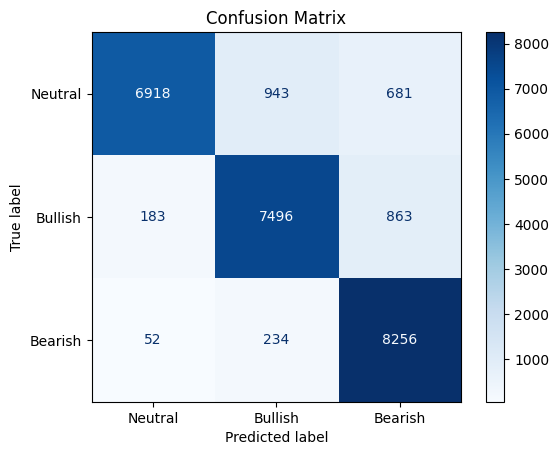


Classification Report:
              precision    recall  f1-score   support

     Neutral     0.9671    0.8099    0.8816      8542
     Bullish     0.8643    0.8775    0.8709      8542
     Bearish     0.8424    0.9665    0.9002      8542

    accuracy                         0.8846     25626
   macro avg     0.8913    0.8846    0.8842     25626
weighted avg     0.8913    0.8846    0.8842     25626



In [ ]:
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report ,confusion_matrix, ConfusionMatrixDisplay
# Define the loss criterion
criterion = nn.CrossEntropyLoss()

# Validate the model
val_loss, val_accuracy, predictions, labels = validate_model(model, validation_loader1, criterion, device)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

cm = confusion_matrix(labels, predictions)
classes = ["Neutral", "Bullish", "Bearish"]  # Replace with your actual class names

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

report = classification_report(labels, predictions, target_names=classes, digits=4)
print("\nClassification Report:")
print(report)